# 混淆矩阵

## 设置Matplotlib中文字体

In [2]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [4]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2025-06-27 15:36:07--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf”

/environment/minico 100%[===================>]   9.58M  13.1MB/s    用时 0.7s    

2025-06-27 15:36:08 (13.1 MB/s) - 已保存 “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf” [10050868/10050868])



## 导入工具包

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [6]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['乌龟', '仓鼠', '兔子', '狗', '猫', '金鱼', '鹦鹉']


## 载入测试集预测结果表格

In [7]:
df = pd.read_csv('测试集预测结果.csv')

In [8]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,乌龟-预测置信度,仓鼠-预测置信度,兔子-预测置信度,狗-预测置信度,猫-预测置信度,金鱼-预测置信度,鹦鹉-预测置信度
0,dataset_split/val/乌龟/0.jpg,0,乌龟,0.0,乌龟,5.0,金鱼,3.0,狗,1.0,0.999790,0.000013,5.688636e-07,0.000019,0.000015,0.000151,0.000012
1,dataset_split/val/乌龟/106.jpg,0,乌龟,0.0,乌龟,6.0,鹦鹉,5.0,金鱼,1.0,0.970566,0.000354,9.084896e-04,0.000648,0.001596,0.005402,0.020526
2,dataset_split/val/乌龟/115.jpg,0,乌龟,0.0,乌龟,5.0,金鱼,1.0,仓鼠,1.0,0.963122,0.004735,5.228490e-04,0.002156,0.000909,0.027109,0.001446
3,dataset_split/val/乌龟/123.jpg,0,乌龟,0.0,乌龟,5.0,金鱼,6.0,鹦鹉,1.0,0.991517,0.000895,2.685588e-04,0.000279,0.000088,0.003942,0.003010
4,dataset_split/val/乌龟/164.jpg,0,乌龟,0.0,乌龟,5.0,金鱼,3.0,狗,1.0,0.999598,0.000010,6.147398e-05,0.000088,0.000022,0.000191,0.000030


## 生成混淆矩阵

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [11]:
confusion_matrix_model.shape

(7, 7)

In [12]:
confusion_matrix_model

array([[78,  0,  0,  0,  0,  0,  0],
       [ 0, 83,  2,  0,  2,  0,  0],
       [ 0,  2, 54,  3,  1,  0,  0],
       [ 0,  1,  0, 95,  0,  0,  0],
       [ 0,  1,  0,  1, 89,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  2],
       [ 0,  1,  0,  0,  0,  0, 96]])

## 可视化混淆矩阵

In [13]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [14]:
# 查看所有配色方案
# dir(plt.cm)

In [15]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

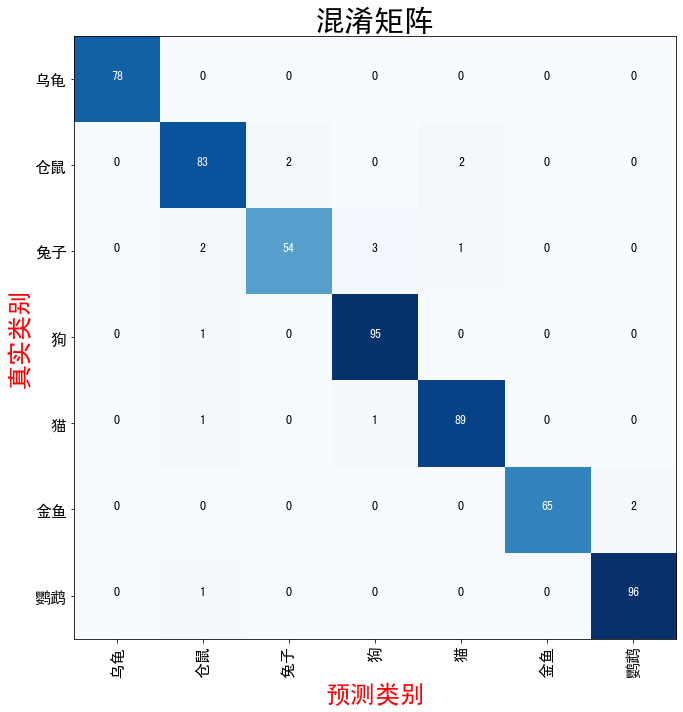

In [16]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [25]:
true_A = '金鱼'
pred_B = '鹦鹉'

In [26]:
wrong_df = df[(df['标注类别名称']==true_A)&(df['top-1-预测名称']==pred_B)]

In [27]:
wrong_df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,乌龟-预测置信度,仓鼠-预测置信度,兔子-预测置信度,狗-预测置信度,猫-预测置信度,金鱼-预测置信度,鹦鹉-预测置信度
419,dataset_split/val/金鱼/16.jpg,5,金鱼,6.0,鹦鹉,5.0,金鱼,4.0,猫,1.0,0.000573,0.001382,0.000889,0.000323,0.002424,0.049115,0.945295
457,dataset_split/val/金鱼/363.jpg,5,金鱼,6.0,鹦鹉,5.0,金鱼,4.0,猫,1.0,0.023766,0.060880,0.030937,0.012560,0.072567,0.323821,0.475469


## 可视化上表中所有被误判的图像

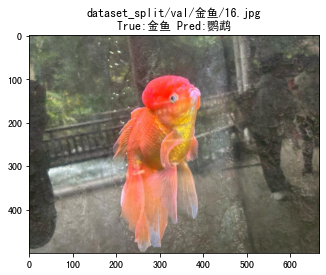

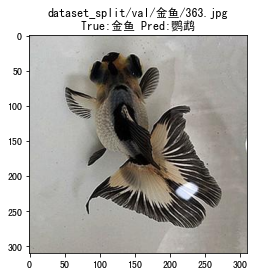

In [28]:
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()